# Андан на экономе: домашнее задание 3


**ФИО:** Хачатрян Виктория

**Твой любимый аник:** идёт медведь по лесу, наступил на колобка, смотрит вниз и говорит: блин

In [3]:
import numpy as np
import pandas as pd

import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

# Спрос на велосипеды

В этой домашке мы будем работать с данными о спросе на велосипеды. Мы научимся его предсказывать.

In [4]:
df = pd.read_csv('/content/bikes_rent.csv')
print(df.shape)
df.head( )

(731, 13)


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


__Описание переменных:__

* `season`  1 - весна, 2 - лето, 3 - осень, 4 - зима
* `yr`  0 - 2011, 1 - 2012
* `mnth`  от 1 до 12
* `holiday`  0 - нет праздника, 1 - есть праздник
* `weekday`  от 0 до 6
* `workingday`  0 - нерабочий день, 1 - рабочий день
* `weathersit`  оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* `temp`  температура в Цельсиях
* `atemp`  температура по ощущениям в Цельсиях
* `hum`  влажность
* `windspeed(mph)`  скорость ветра в милях в час
* `windspeed(ms)`  скорость ветра в метрах в секунду
* `cnt`  количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

In [5]:
# Функция для того, чтобы на одной картинке смотреть те графики с прогнозами.
def plot_yreal_ypred(y_test, y_train, y_test_hat, y_train_hat):
    """
        Рисует картинку для прогнозов регрессии
    """

    margin = 0.1 # отступ на границах
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(y_train, y_train_hat, color="red", alpha=0.5)
    plt.xlabel('Истинные значения')
    plt.ylabel('Предсказанные значения')
    plt.axis('equal')
    plt.axis('square')
    train_min = min(y_train)
    train_max = max(y_train)
    plt.xlim(train_min - margin, train_max + margin)
    plt.ylim(train_min - margin, train_max + margin)
    plt.plot([-10000, 10000], [-10000, 10000])
    plt.title('Train set', fontsize=20)

    plt.subplot(122)
    plt.scatter(y_test, y_test_hat, color="red", alpha=0.5)
    plt.xlabel('Истинные значения')
    plt.ylabel('Предсказанные значения')
    plt.axis('equal')
    plt.axis('square')
    test_min = min(y_test)
    test_max = max(y_test)
    plt.xlim(test_min - margin, test_max + margin)
    plt.ylim(test_min - margin, test_max + margin)
    plt.plot([-10000, 10000], [-10000, 10000])
    plt.title('Test set', fontsize=20)
    pass

## 1. EDA

__а) [5 баллов]__ Проверьте, есть ли в данных пропуски

In [6]:
missing_values = df.isnull().sum() #ну тут все понятно, не думаю, что нужен комментарий

if missing_values.sum() > 0:
    print("В данных есть пропуски.")
else:
    print("В данных нет пропусков.")

В данных нет пропусков.


__б) [5 баллов]__ Составьте список из категориальных переменных и список из действительных переменных.

In [7]:
var_cat = ['season', 'yr', 'holiday','mnth', 'weekday', 'workingday', 'weathersit'] #в чем суть этого задания? либо я ну очень тупая, либо задание очень простое?
var_real = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', ]
target = 'cnt'

print("Категориальные переменные:", var_cat)
print("Действительные переменные:", var_real)
print("Целевая переменная:", target)

Категориальные переменные: ['season', 'yr', 'holiday', 'mnth', 'weekday', 'workingday', 'weathersit']
Действительные переменные: ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']
Целевая переменная: cnt


__в) [5 баллов]__ Нарисуйте гистограмму для целевого признака. Что можете сказать о его хвосте? Надо ли предпринять какие-нибудь манипуляции, связанные с борьбой с выбросами?

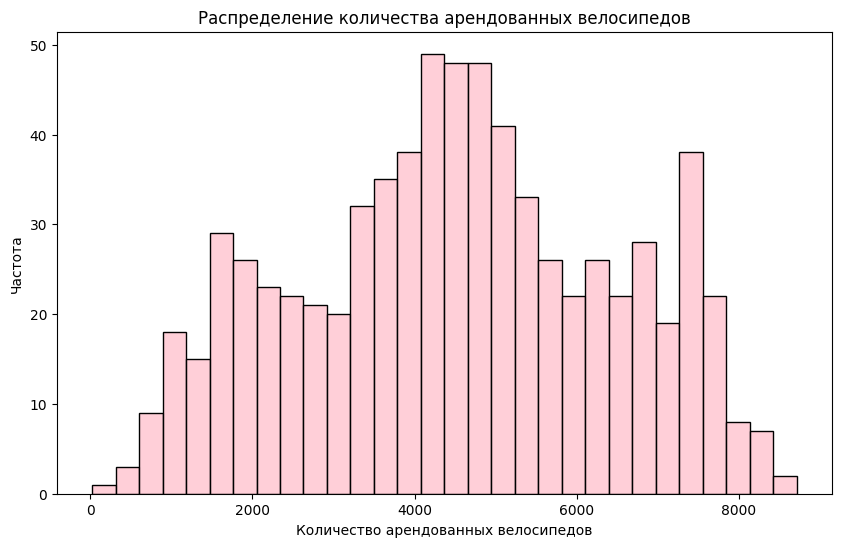

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df['cnt'], bins=30, color='pink')
plt.title('Распределение количества арендованных велосипедов')
plt.xlabel('Количество арендованных велосипедов')
plt.ylabel('Частота')
plt.show()

__Ответ:__  По сути, на графике видно, что данные выглядят как нормальное распределение, но есть какие-то выбросы в хвостах, что может быть результатом аномалий или редких событий. Стоит понять, что за выбросы и что их вызвало, а после этого уже решить, что с ними делать: удалить, переделать данные или использовать какие-то специальные методы, чтобы они не мешали анализу.

__г) [5 баллов]__ Давайте посмотрим на то, как переменные коррелируют с таргетом. Для этого постройте соответствующую облака рассеивания.

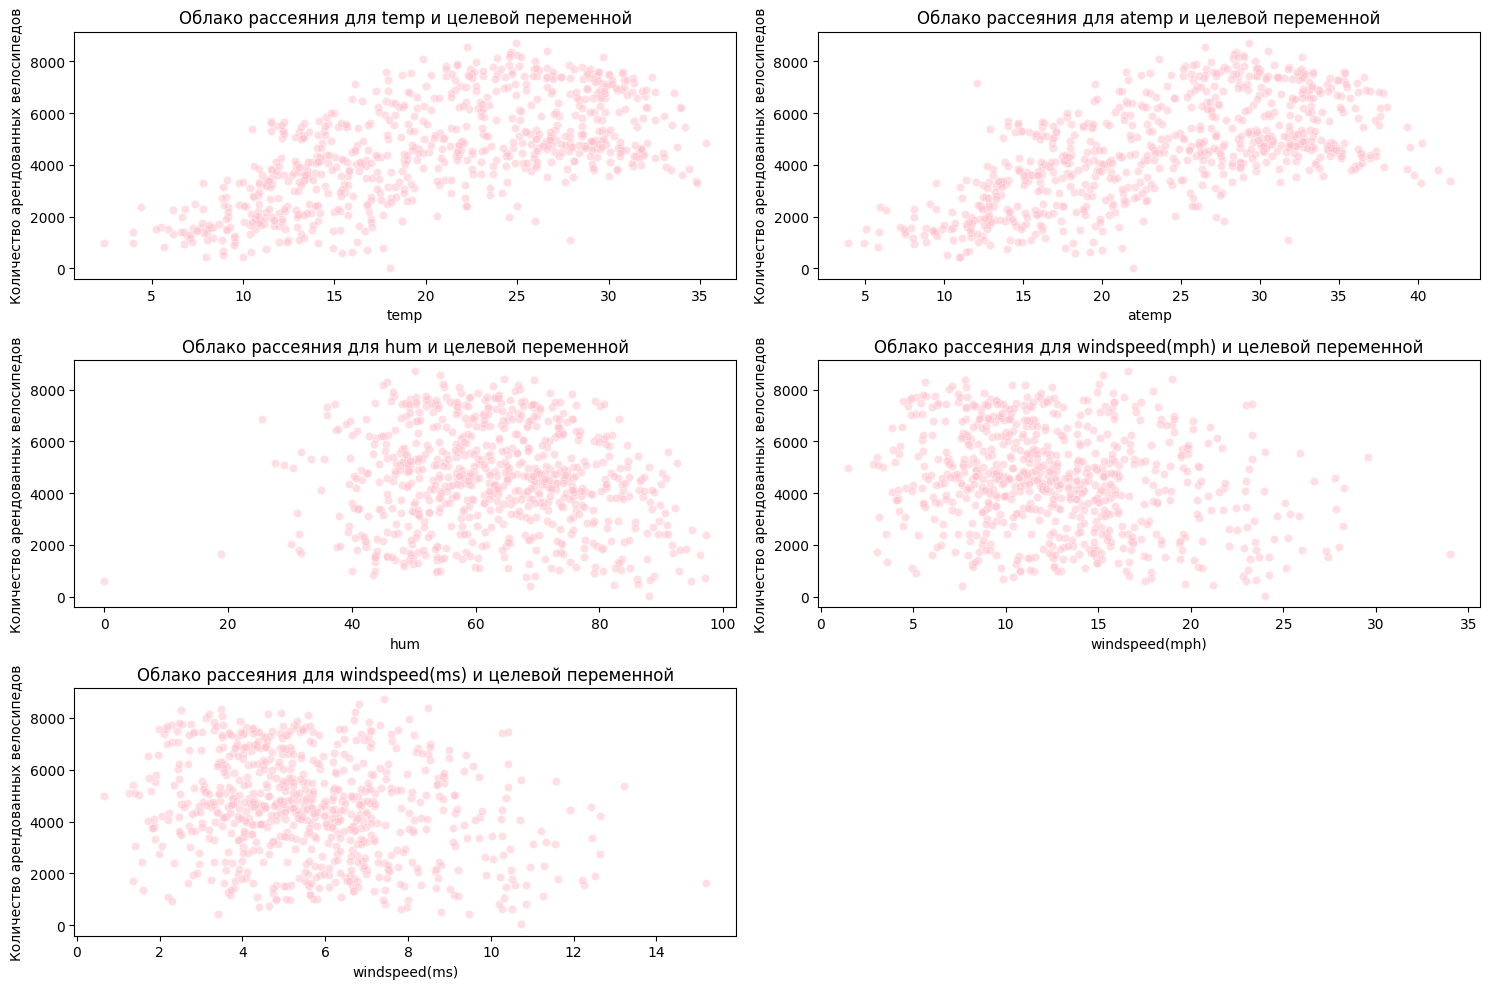

In [9]:
#для действительных переменных
plt.figure(figsize=(15, 10))
for i, var in enumerate(var_real):
    plt.subplot(3, 2, i+1)     #создаем "подграфик" внутри главного графика
    sns.scatterplot(x=var, y=target, data=df, alpha=0.5, color='pink')
    plt.title(f'Облако рассеяния для {var} и целевой переменной')
    plt.xlabel(var)
    plt.ylabel('Количество арендованных велосипедов')
plt.tight_layout()
plt.show()

я сначала написала вот такой код:

```
plt.figure(figsize=(10, 6))
for i in var_real:
    sns.scatterplot(x=i, y='cnt', data=df, alpha=0.5, color='pink')
    plt.title(f'Облако рассеяния для {i} и целевой переменной')
    plt.xlabel(i)
    plt.ylabel('Количество арендованных велосипедов')
    plt.grid(True)
    plt.show()

```
но он был некрасивым (графики выходили разных размеров). Попросила chat GPT исправить. Он исправил, а я все поняла.


__д) [5 баллов]__ Каков характер зависимости числа прокатов от месяца? От каких признаков спрос зависит линейно?

__Ответ:__  В предыдущих графиках можно увидеть, что существует линейная зависимость между спросом на аренду велосипедов и температурой в Цельсиях (`temp`) и температурой по ощущениям в Цельсиях (`atemp`).


__е) [5 баллов]__ Постройте гистограммы для всех непрерывных переменных. Что можете сказать о выбросах?

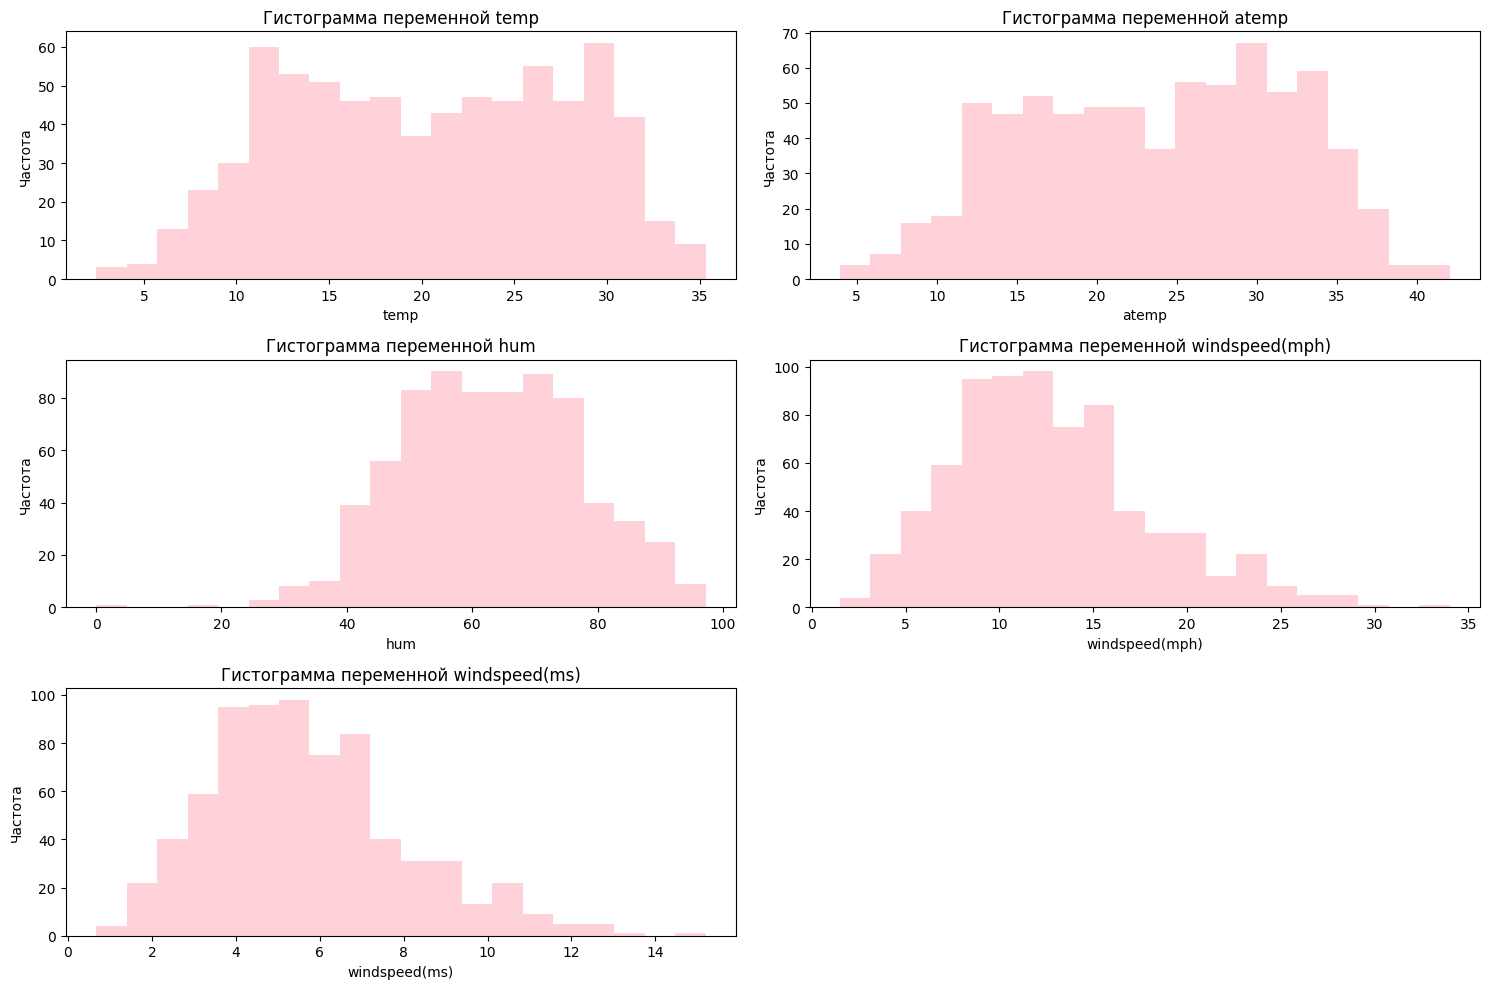

In [10]:
plt.figure(figsize=(15, 10))
for i, var in enumerate(var_real):
    plt.subplot(3, 2, i+1)
    plt.hist(df[var], bins=20, color='pink', alpha=0.7)
    plt.title(f'Гистограмма переменной {var}')
    plt.xlabel(var)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()
#это я уже сама написала по примеру предыдущего,который мне gpt написал

Исходя из гистограмм windspeed(mph) и windspeed(ms), можно сказать, что эти непрерывные переменные имеют длинные хвосты, что может указывать на наличие выбросов в данных. Они могут быть вызваны аномалиями в погоде или другими редкими событиями.

В целом, из гистограмм можно сказать, что распределение непрерывных переменных отдаленно напоминает нормальное распределение, с унимодальной формой и плавным спадом по обе стороны от пика. Однако, присутствие длинных хвостов на графиках указывает на возможное наличие выбросов в данных.

__ж) [5 баллов]__ Постройте между непрерывными признаками корреляционную матрицу. Нарисуйте её. Какие признаки, скорее всего, неинформативны? Почему они на ваш взгляд такие?

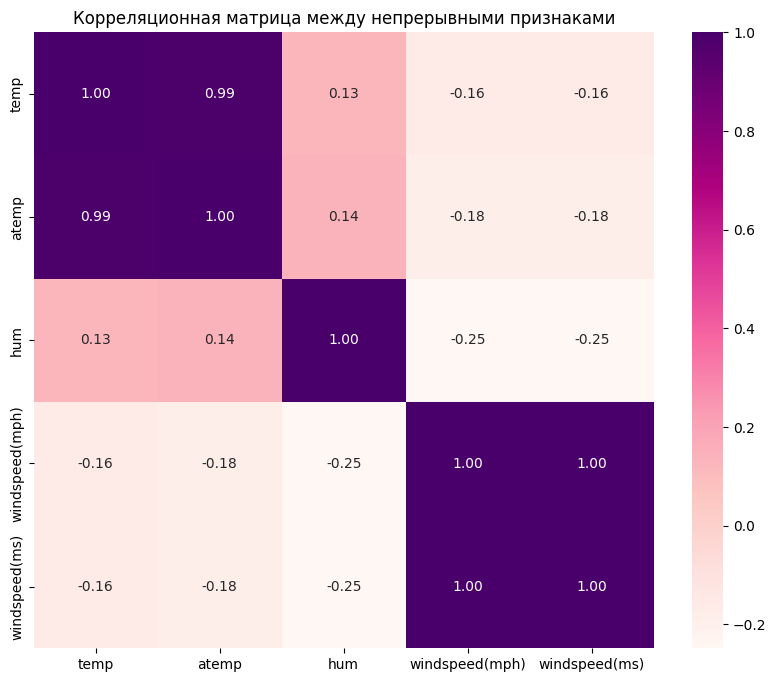

In [11]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[var_real].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdPu', fmt=".2f") #самое веселое, что я не люблю розовый цвет, но в этой домашке меня занесло
plt.title('Корреляционная матрица между непрерывными признаками')
plt.show()

__Ответ:__

Признаки `windspeed(mph)` и `windspeed(ms)` скорее всего неинформативны, так как они имеют очень низкую корреляцию с целевой переменной `cnt` и с другими признаками.

Признак `hum` тоже кажется неинформативным (имеет низкую корреляцию с целевой переменной и остальными признаками).

А вот признаки `temp` и `atemp` сильно коррелируют между собой (корреляция близка к 1).

__з) [5 баллов]__ Постройте для всех категориальных переменных _countplot_. Что интересного вы видите в распределеии этих признаков?  Встречаются ли слишком обширные категории, в которых очень маленькие части нам придётся объединять в категорию "другое"?

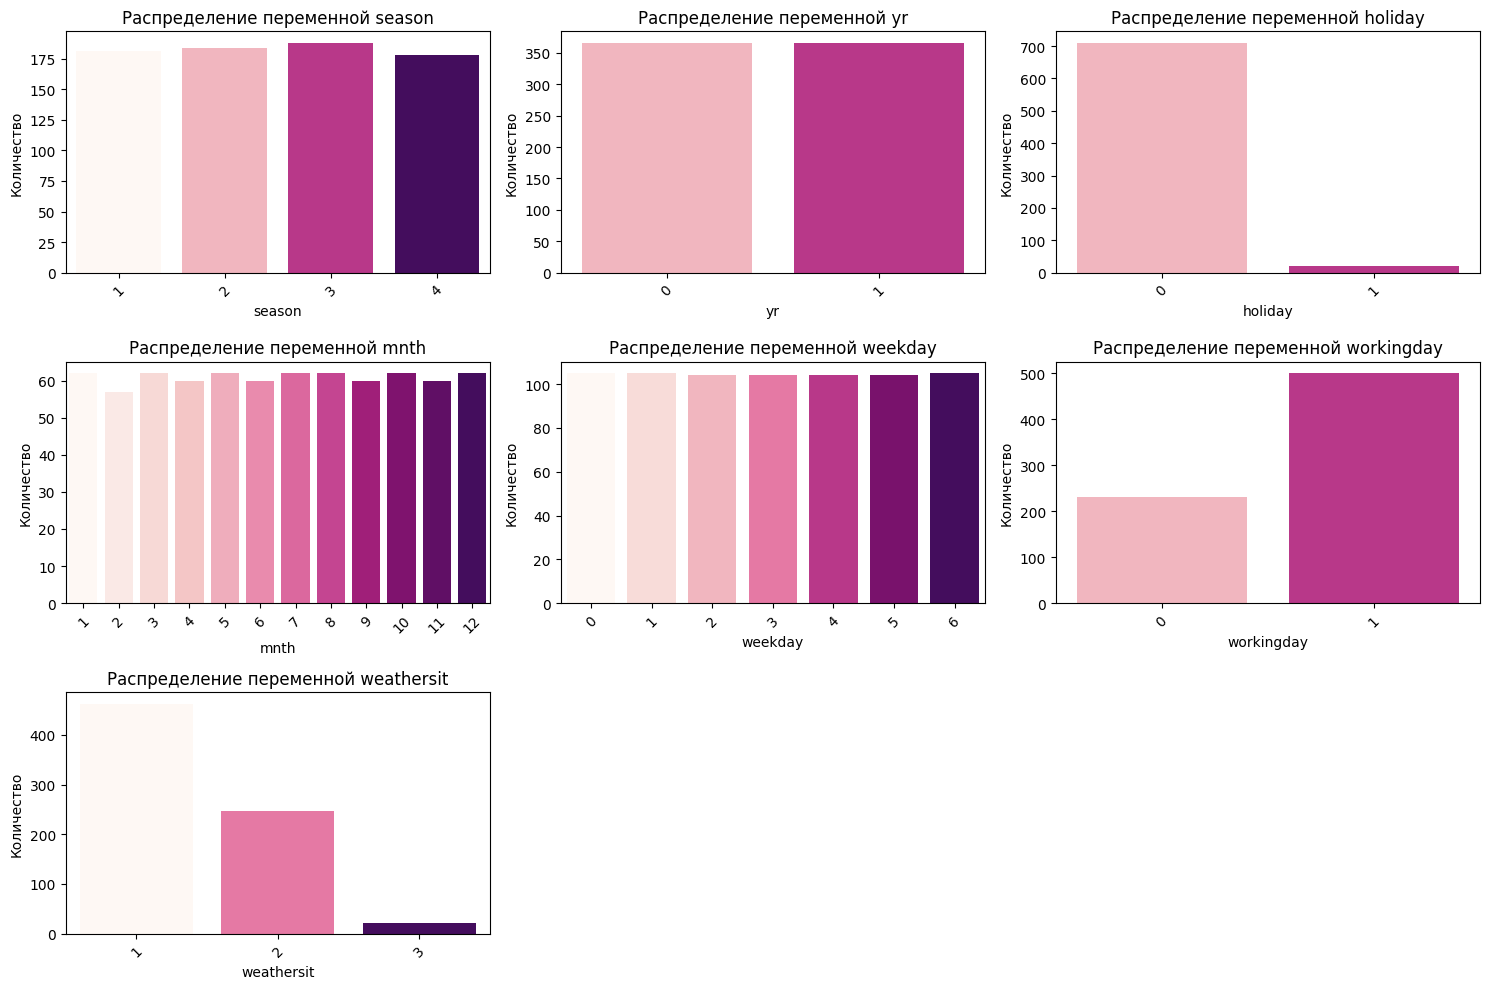

In [13]:
plt.figure(figsize=(15, 10))
for i, var in enumerate(var_cat):  #ну я уже ас в написании таких кодов (заметили какая я эрудированная? сложные слова знаю)
    plt.subplot(3, 3, i+1)
    sns.countplot(x=var, data=df, palette='RdPu', hue=var, legend=False)
    plt.title(f'Распределение переменной {var}')
    plt.xlabel(var)
    plt.ylabel('Количество')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


__Ответ:__  

- Зависимость от времени года: В летний сезон наблюдается наибольшее количество аренд. Это может быть связано с тем, что в теплое время года больше людей хотят активно проводить время на улице. Но tbh я думала летом премо бум будет, так что есть вопросики к данным (или к моему анализу).

- Спрос в различные месяцы: Некоторые месяцы, особенно весенне-летние, имеют более высокий спрос на аренду велосипедов, чем другие. Но опятъ же, разница незначительная.

- Распределение по дням недели: На графике наблюдается примерно одинаковое распределение аренды велосипедов в разные дни недели. Это указывает на то, что спрос на аренду велосипедов не сильно зависит от дня недели. Возможно, целевая аудитория арендаторов велосипедов имеет свободное время для катания как в выходные, так и в будние дни.
Однако заметна разница между рабочими и нерабочими днями. Хотя в праздники не так часто берут велосипеды в аренду, что понятно — съесть ведро оливье привлекательнее, чем аренда велосипеда.

- Влияние погоды: Погодные условия существенно влияют на спрос на аренду велосипедов. Например, в хорошую погоду (weathersit=1) спрос выше, чем в плохую.

- Обширные категории: В данном случае нет необходимости объединять малые части данных в категорию "другое". И снова неуверенность в репрезентативности данных, что-то не очень все клеется.


__и) [5 баллов]__  Сделайте OHE-кодирование. Сколько свежих OHE-признаков у нас появилось?

In [14]:
df_ohe = pd.get_dummies(df, columns=var_cat)
num_new_features = len(df_ohe.columns) - len(df.columns)
num_new_features

25

__к) [5 баллов]__   Некоторые из наших переменных могут вносить в спрос на велики квадратичный вклад. Например, температура.

Сначала, когда температура возрастает, люди выходят кататься охотнее, а потом, когда становится жарко, спрос резко падает. Так возникает параболическая зависимость.

Создайте для каждой действительной переменной из данных дополнительную переменную: её квадрат.

In [15]:
for var in var_real:
    df[var + 'kvadrat'] = df[var] ** 2
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt,tempkvadrat,atempkvadrat,humkvadrat,windspeed(mph)kvadrat,windspeed(ms)kvadrat
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985,199.116003,330.557852,6493.668239,115.559963,23.092738
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801,222.087427,312.828200,4845.371116,277.292867,55.412371
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349,64.817377,89.685635,1912.076765,276.779887,55.309860
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562,67.240000,112.489357,3486.134892,115.343991,23.049580
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600,86.587436,131.411832,1909.314198,156.807997,31.335472


__л) [5 баллов]__  Попробуйте придумать ещё какую-нибудь новую фичу (дополнительную переменную) для прогнозирования. Опишите какая за вашей фичёй стоит интуиция и почему это должно сработать при моделировании.

In [16]:
#можем создать индекс комфорта, учитывающий температуру, влажность и скорость ветра, используя формулу,
#которая учитывает влияние каждого из этих факторов на комфортность погоды.
#этот индекс можно рассматривать как улучшенную версию atemp

df['comfort'] = df['temp'] + df['hum'] - df['windspeed(mph)']
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt,tempkvadrat,atempkvadrat,humkvadrat,windspeed(mph)kvadrat,windspeed(ms)kvadrat,comfort
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985,199.116003,330.557852,6493.668239,115.559963,23.092738,83.944265
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801,222.087427,312.828200,4845.371116,277.292867,55.412371,67.859185
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349,64.817377,89.685635,1912.076765,276.779887,55.309860,35.141521
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562,67.240000,112.489357,3486.134892,115.343991,23.049580,56.503668
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600,86.587436,131.411832,1909.314198,156.807997,31.335472,40.478637


Новая переменная "комфорт" представляет собой меру комфортности погоды, которая вычисляется как разница между температурой и влажностью. Более высокие значения этой переменной указывают на более комфортные погодные условия, когда тепло и сухо, в то время как более низкие значения могут указывать на менее комфортные условия, когда холодно и влажно или жарко и влажно. Интуитивно люди предпочитают выходить на улицу на велосипеды в более комфортную погоду, поэтому она может быть полезной для прогнозирования спроса на велосипеды.

## 2. Обучение модели

__а) [10 баллов]__  Разбейте выборку на тренировочную и тестовую.

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['cnt']), df['cnt'], test_size=0.2)


#https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas но на самом деле я еще много всяких индусов на ютубе посмотрела, чтобы понять, что тут происходит

__б) [10 баллов]__ Возьмите RMSE в качестве метрики качества. Для этого нужно написать свою функцию. Постройте наивный прогноз (среднее) и найдите для него RMSE.

In [21]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

mean_prediction = np.mean(y_train)  #среднее значение целевой переменной для всех наблюдений в тренировочной выборке

mean_predictions = np.full_like(y_test, mean_prediction)  #предсказанные значения равны среднему значению целевой переменной

rmse_mean_prediction = calculate_rmse(y_test, mean_predictions)  #вычисление RMSE, где предсказанные значения равны среднему значению

print("RMSE для наивного прогноза (среднее значение):", rmse_mean_prediction)



RMSE для наивного прогноза (среднее значение): 2032.4680432761484


__в) [5 баллов]__ Запустите код с разбиением выборки на тренировочную и тестовую, подсчётом наивного прогноза и RMSE по нему несколько раз. НЕ НАДО НИЧЕГО КОПИРОВАТЬ. ПРОСТО ПЕРЕЗАПУСТИТЕ КОД ТРИ РАЗА. Меняется ли RMSE? Почему оно меняется? К чему плохому это может привести при обучении? Как это обычно исправляют?

__Ответ:__  
RMSE меняется при каждом запуске кода, это означает, что каждый раз используется новое случайное разбиение данных на тренировочную и тестовую выборки.

Это приводит к тому, что оценка качества модели будет нестабильной и зависеть от конкретного случайного разбиения данных, что затрудняет сравнение различных моделей и принятие решений на основе оценки качества модели.

Для устранения этой проблемы можно использовать метод перекрестной проверки (cross-validation), который позволяет усреднить результаты оценки качества модели по нескольким разбиениям данных, что позволит получить более надежные оценки качества модели и уменьшить влияние случайного разбиения данных на результаты обучения.

__г) [10 баллов]__ Оцените линейную регрессию. Насколько удалось улучшить качество прогнозирования в сравнении с наивным прогнозом?  Визуализируйте прогнозы функцией `plot_yreal_ypred`.

Что вы видите на этой визуализации? Проинтерпретируйте картинку.

In [22]:
from sklearn.linear_model import LinearRegression

#обучение линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_linear_regression = model.predict(X_test)

rmse_linear_regression = calculate_rmse(y_test, y_pred_linear_regression)
print("RMSE для линейной регрессии:", rmse_linear_regression)



RMSE для линейной регрессии: 838.4723654067301


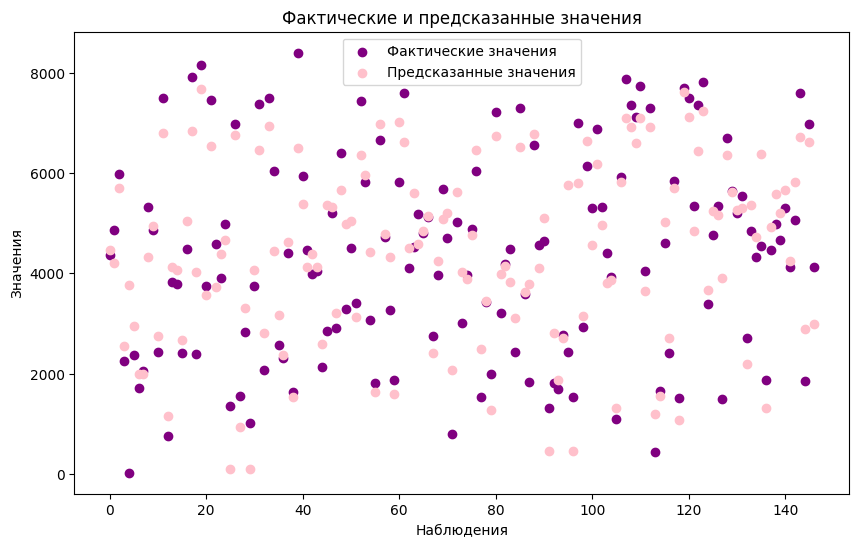

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='purple', label='Фактические значения')
plt.scatter(range(len(y_test)), y_pred_linear_regression, color='pink', label='Предсказанные значения')
plt.xlabel('Наблюдения')
plt.ylabel('Значения')
plt.title('Фактические и предсказанные значения')
plt.legend()
plt.show()


__Ответ:__
RMSE для линейной регрессии меньше более чем в два раза по сравнению с наивным прогнозом, это говорит о значительном улучшении качества прогнозирования.

На визуализации с диаграммой рассеяния мы видим, что розовые точки (предсказанные значения) в целом тесно следуют за фиолетовыми точками (фактические значения). Это указывает на то, что линейная регрессия достаточно точно предсказывает целевую переменную и улучшает качество прогнозирования по сравнению с наивным прогнозом.

__д) [10 баллов]__ Какими получились значения перед коэффициентами у вашей модели?  Как думаете, почему такое произошло?



In [24]:
#получение коэффициентов модели
coefficients = model.coef_
print("Значения коэффициентов модели:", coefficients)

Значения коэффициентов модели: [ 4.95103398e+02  1.89637314e+03 -6.58450263e+01 -3.28076084e+02
  6.13168655e+01  7.31837081e+01 -4.04425627e+02  8.53578704e+11
 -2.42710609e+02  8.53578704e+11  2.56334790e+12 -7.64366482e+12
 -1.44672226e+01  4.05971815e+00 -6.59327806e-01 -5.52366221e+10
  2.76413392e+11 -8.53578704e+11]


__Ответ:__  Значения перед коэффициентами в нашей модели показывают, как каждый признак влияет на целевую переменную. Положительные коэффициенты указывают на положительную зависимость между признаком и целевой переменной: увеличение значения признака приводит к увеличению целевой переменной, и наоборот. Отрицательные коэффициент указывают на отрицательную зависимость: увеличение значения признака приводит к уменьшению целевой переменной, и наоборот.

Возможные причины, по которым значения перед коэффициентами могут отличаться, могут включать в себя масштабирование признаков (если признаки имеют разный масштаб) или мультиколлинеарность (если два или более признаков сильно коррелируют друг с другом). Также значения коэффициентов могут быть искажены из-за выбросов в данных или недостаточной информации для моделирования.

## 3. Бонус

Привет!

Вместо бонусного задания пишу тебе небольшое бонусное письмо.
Спасибо за лояльную проверку!!! Огромное спасибо. (Будет смешно, если эта домашка у меня будет на защиту, но если что, я готова, я честно все указала и поняла.)

Хотелось бы в конце написать смешную шутку, но я не смогла ничего вспомнить. ГПТ как всегда в помощь:

*Почему программисты всегда ходят с синими экранами на своих компьютерах?*
*Потому что им всегда не хватает идеи!*

Если честно, я шутку совсем не поняла, но может это какая-то айтишная тема. (Я очень надеюсь, что она никого не оскорбляет, я реально ее не понимаю и вставила чисто по фану.)